# BIZ 프로젝트 : 부실기업 예측

## Step2 : 데이터 전처리

부실기업은 과거 3년간 연속해 이자보상 배율이 1.0미만인 기업을 의미하며  
이를 이용하여 타겟변수인 부실기업여부 변수를 생성

### 필요라이브러리 불러오기

In [1]:
import pandas as pd
import numpy as np

### 데이터 불러오기

In [8]:
RANDOM_STATE = 110

data = pd.read_csv("../../project/data/clean_financial_data.csv", encoding='utf-8-sig', low_memory=False)
print(data.shape)

(38639, 543)


In [3]:
data.columns

Index(['업체코드', '종목코드', '종목명', '2020/총자산증가율', '2021/총자산증가율', '2022/총자산증가율',
       '2023/총자산증가율', '2024/총자산증가율', '2020/유형자산증가율', '2021/유형자산증가율',
       ...
       '2020/조세공과(구성비)', '2021/조세공과(구성비)', '2022/조세공과(구성비)', '2023/조세공과(구성비)',
       '2024/조세공과(구성비)', '2020/감가상각비(구성비)', '2021/감가상각비(구성비)',
       '2022/감가상각비(구성비)', '2023/감가상각비(구성비)', '2024/감가상각비(구성비)'],
      dtype='object', length=543)

In [9]:
# '영업이익이자보상비율'이 포함된 열들 찾기
columns_with_ratio = [col for col in data.columns if '영업이익이자보상비율' in col]

# 각 열에 대해 결측치 개수와 비율 계산
missing_data = data[columns_with_ratio].isnull().sum()
missing_ratio = (missing_data / len(data)) * 100  # 결측치 비율 계산 (퍼센트)

# 결측치가 있는 열만 출력
missing_summary = pd.DataFrame({
    '결측치 개수': missing_data,
    '결측치 비율 (%)': missing_ratio
}).loc[missing_data > 0]

# 결과 출력
print(missing_summary)


                 결측치 개수  결측치 비율 (%)
2020/영업이익이자보상비율    8768   22.692099
2021/영업이익이자보상비율    6378   16.506638
2022/영업이익이자보상비율    4472   11.573798
2023/영업이익이자보상비율    4810   12.448562
2024/영업이익이자보상비율   37943   98.198711


- 2024년 데이터는 target변수인 '영업이익이자보상비율'의 대부분이 결측치이므로 제거

In [10]:
# '2024'가 열 이름에 포함된 열들을 제거
data = data.drop(columns=[col for col in data.columns if '2024' in col], errors='ignore')
print(data.shape)

(38639, 435)


In [11]:
# '영업이익이자보상비율'이 포함된 열들 찾기
columns_with_ratio = [col for col in data.columns if '영업이익이자보상비율' in col]

# 결측치가 있는 행 제거
data = data.dropna(subset=columns_with_ratio)

# 결과 확인
print(data.shape)

(27604, 435)


In [12]:
# 각 열의 결측값을 중앙값으로 대체
data = data.fillna(data.median(numeric_only=True))

In [13]:
data.dtypes

업체코드                object
종목코드                object
종목명                 object
2020/총자산증가율        float64
2021/총자산증가율        float64
                    ...   
2023/조세공과(구성비)     float64
2020/감가상각비(구성비)    float64
2021/감가상각비(구성비)    float64
2022/감가상각비(구성비)    float64
2023/감가상각비(구성비)    float64
Length: 435, dtype: object

In [14]:
# 숫자형 변수 개수 확인
numeric_columns = data.select_dtypes(include=['number']).columns
numeric_count = len(numeric_columns)

print(f"숫자형 변수 개수: {numeric_count}개")

숫자형 변수 개수: 432개


C:\Users\ldb76\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52509 (\N{HANGUL SYLLABLE CONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ldb76\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ldb76\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ldb76\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51613 (\N{HANGUL SYLLABLE JEUNG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ldb76\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 4

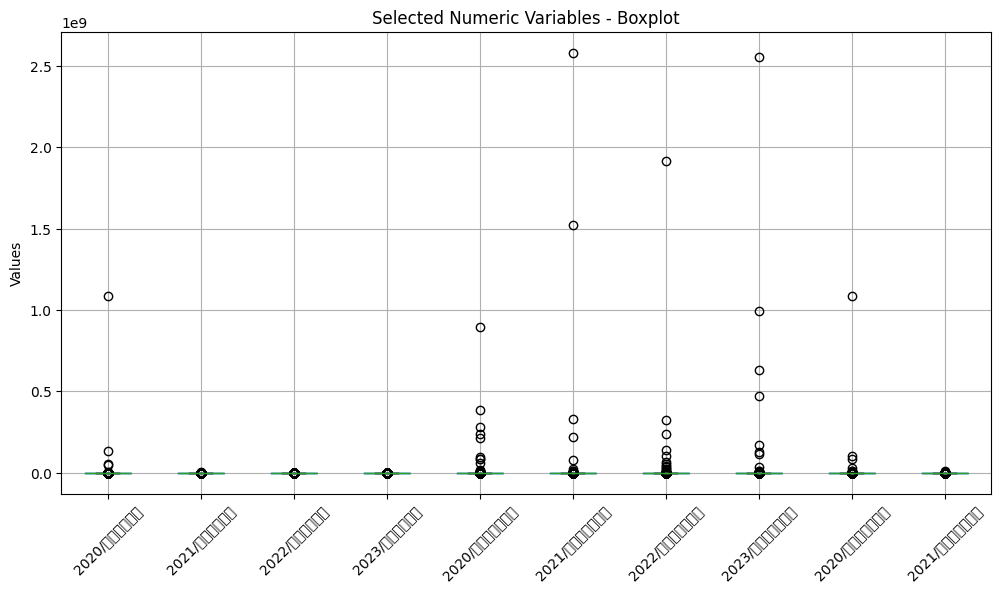

In [15]:
import matplotlib.pyplot as plt

# 숫자형 변수 선택
numeric_columns = data.select_dtypes(include=['number']).columns

# 숫자형 변수 중 일부 선택 (예: 앞에서 10개)
selected_columns = numeric_columns[:10]

# 선택된 변수에 대한 박스플롯 그리기
plt.figure(figsize=(12, 6))
data[selected_columns].boxplot(rot=45)
plt.title("Selected Numeric Variables - Boxplot")
plt.ylabel("Values")
plt.show()


In [16]:
from scipy.stats.mstats import winsorize

# 숫자형 데이터에만 윈저라이징 적용
numeric_columns = data.select_dtypes(include=['number']).columns

for col in numeric_columns:
    # 0.01 이하와 0.99 이상을 해당 값으로 제한
    lower_limit = data[col].quantile(0.01)
    upper_limit = data[col].quantile(0.99)
    data[col] = data[col].clip(lower=lower_limit, upper=upper_limit)


data.head(5)


,업체코드,종목코드,종목명,2020/총자산증가율,2021/총자산증가율,2022/총자산증가율,2023/총자산증가율,2020/유형자산증가율,2021/유형자산증가율,2022/유형자산증가율,...,2022/임차료(구성비),2023/임차료(구성비),2020/조세공과(구성비),2021/조세공과(구성비),2022/조세공과(구성비),2023/조세공과(구성비),2020/감가상각비(구성비),2021/감가상각비(구성비),2022/감가상각비(구성비),2023/감가상각비(구성비)
0,N350605,A000020,동화약품,7.57,2.70,3.27,10.23,19.67,10.41,7.64,...,1.32,1.41,2.14,2.11,2.12,2.13,7.96,7.83,8.03,8.22
1,N320498,A000040,KR모터스,-36.76,1.45,-0.52,-4.89,-0.29,5.78,4.85,...,1.32,1.41,2.14,2.11,2.12,2.13,7.96,7.83,8.03,8.22
2,N320684,A000050,경방,-6.47,0.15,-6.09,-1.40,-36.42,-23.56,665.18,...,1.32,1.41,2.14,2.11,2.12,2.13,7.96,7.83,8.03,8.22
3,N320730,A000070,삼양홀딩스,6.31,22.28,-0.76,17.63,-45.53,943.89,0.68,...,1.32,1.41,2.14,2.11,2.12,2.13,7.96,7.83,8.03,8.22
4,N310581,A000080,하이트진로,-0.99,10.65,-9.43,-0.03,-6.75,-2.60,-1.51,...,1.32,1.41,2.14,2.11,2.12,2.13,7.96,7.83,8.03,8.22


C:\Users\ldb76\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52509 (\N{HANGUL SYLLABLE CONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ldb76\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ldb76\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ldb76\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51613 (\N{HANGUL SYLLABLE JEUNG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ldb76\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 4

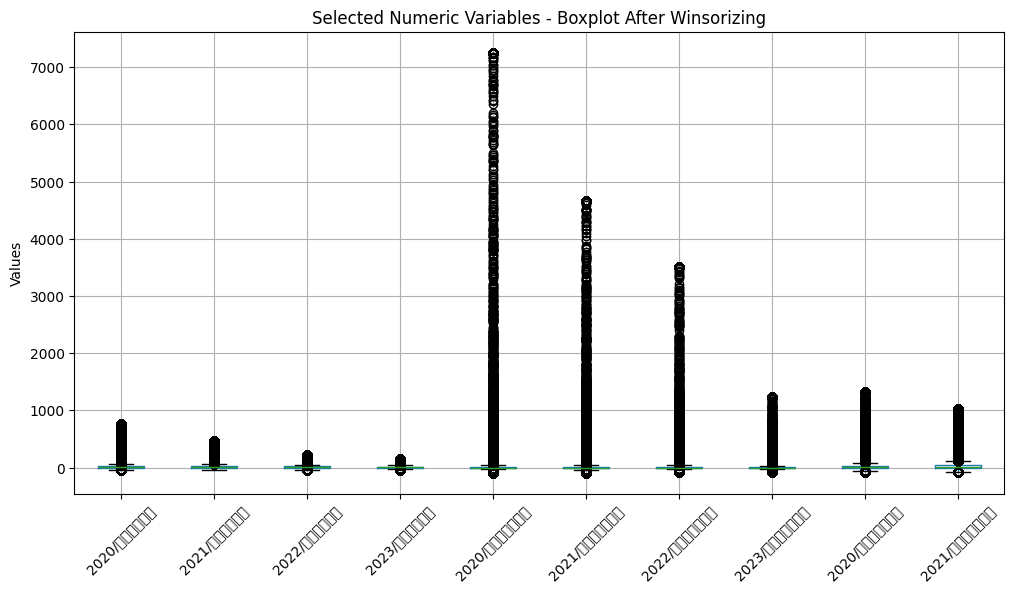

In [ ]:
import matplotlib.pyplot as plt

selected_columns = numeric_columns[:10]  # 이전에 선택한 numeric_columns 그대로 사용

# 윈저라이징 후 선택된 변수에 대한 박스플롯 그리기
plt.figure(figsize=(12, 6))
data[selected_columns].boxplot(rot=45)
plt.title("Selected Numeric Variables - Boxplot After Winsorizing")
plt.ylabel("Values")
plt.show()


c:\Users\ldb76\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ldb76\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\ldb76\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52509 (\N{HANGUL SYLLABLE CONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ldb76\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ldb76\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}

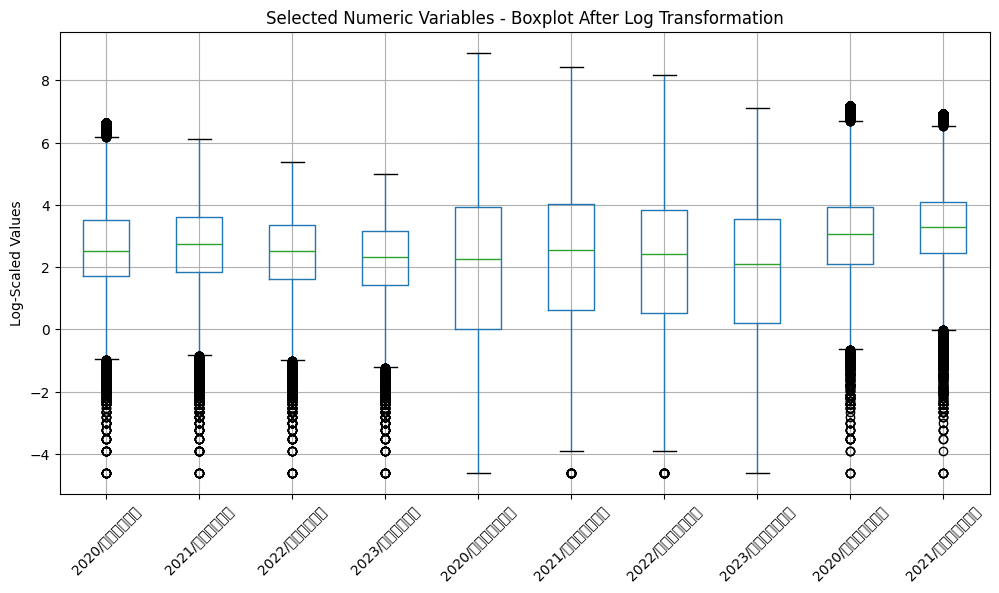

In [18]:
import numpy as np

# 로그 변환
data_log_scaled = data[selected_columns].apply(lambda x: np.log1p(x))

# 로그 변환 후 박스플롯
plt.figure(figsize=(12, 6))
data_log_scaled.boxplot(rot=45)
plt.title("Selected Numeric Variables - Boxplot After Log Transformation")
plt.ylabel("Log-Scaled Values")
plt.show()


In [19]:
data['2021/영업이익이자보상비율'] < 1

0        False
1         True
2        False
3        False
4        False
         ...  
38634     True
38635    False
38636    False
38637    False
38638    False
Name: 2021/영업이익이자보상비율, Length: 27604, dtype: bool

- 0이면 부실기업이 아닌 기업, 1이면 부실기업을 의미

In [20]:
# 2022/부실기업 변수 생성 및 값 할당
data['2022/부실기업'] = ((data['2020/영업이익이자보상비율'] < 1) & 
                        (data['2021/영업이익이자보상비율'] < 1) & 
                        (data['2022/영업이익이자보상비율'] < 1)).astype(int)

# 2023/부실기업 변수 생성 및 값 할당
data['2023/부실기업'] = ((data['2021/영업이익이자보상비율'] < 1) & 
                        (data['2022/영업이익이자보상비율'] < 1) & 
                        (data['2023/영업이익이자보상비율'] < 1)).astype(int)

# 결과 확인
print("\n2022/부실기업 변수 값:")
print(data['2022/부실기업'].value_counts())

print("\n2023/부실기업 변수 값:")
print(data['2023/부실기업'].value_counts())


2022/부실기업 변수 값:
2022/부실기업
0    22672
1     4932
Name: count, dtype: int64

2023/부실기업 변수 값:
2023/부실기업
0    22473
1     5131
Name: count, dtype: int64


C:\Users\ldb76\AppData\Local\Temp\ipykernel_18104\1223814708.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['2022/부실기업'] = ((data['2020/영업이익이자보상비율'] < 1) &
C:\Users\ldb76\AppData\Local\Temp\ipykernel_18104\1223814708.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['2023/부실기업'] = ((data['2021/영업이익이자보상비율'] < 1) &


In [21]:
data.isnull().sum()

업체코드                   0
종목코드               24402
종목명                    1
2020/총자산증가율            0
2021/총자산증가율            0
                   ...  
2021/감가상각비(구성비)        0
2022/감가상각비(구성비)        0
2023/감가상각비(구성비)        0
2022/부실기업              0
2023/부실기업              0
Length: 437, dtype: int64

In [22]:
# '종목명' 열에서 null 값이 있는 행 제거
data = data[data['종목명'].notnull()]

이때 종목코드 x -> 해당 기업이 상장되지 않은 경우

In [23]:
# '종목코드' 열의 값이 있으면 1, 없으면 0을 부여하는 새로운 열 생성
data['상장여부'] = data['종목코드'].notnull().astype(int)

# '종목코드' 열 제거
data = data.drop(columns=['종목코드'])

C:\Users\ldb76\AppData\Local\Temp\ipykernel_18104\292392295.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['상장여부'] = data['종목코드'].notnull().astype(int)


In [24]:
data.isnull().sum()

업체코드               0
종목명                0
2020/총자산증가율        0
2021/총자산증가율        0
2022/총자산증가율        0
                  ..
2022/감가상각비(구성비)    0
2023/감가상각비(구성비)    0
2022/부실기업          0
2023/부실기업          0
상장여부               0
Length: 437, dtype: int64

In [31]:
data.dtypes

업체코드                object
종목명                 object
2020/총자산증가율        float64
2021/총자산증가율        float64
2022/총자산증가율        float64
                    ...   
2022/감가상각비(구성비)    float64
2023/감가상각비(구성비)    float64
2022/부실기업            int32
2023/부실기업            int32
상장여부                 int32
Length: 437, dtype: object

### t-test

In [ ]:
from scipy.stats import ttest_ind

# 타겟 변수 설정
group_0 = data[data['2023/부실기업'] == 0]  # 부실기업이 아닌 그룹
group_1 = data[data['2023/부실기업'] == 1]  # 부실기업 그룹

# 숫자형 변수 선택 및 제외할 열들 제거
numeric_columns = data.select_dtypes(include=['number']).columns.drop(['2022/부실기업', '2023/부실기업'])

# t-검정 결과 저장
t_test_results = []

for col in numeric_columns:
    # 각 변수에 대해 t-검정 수행
    t_stat, p_value = ttest_ind(group_0[col].dropna(), group_1[col].dropna(), equal_var=False)  # Welch's t-test
    t_test_results.append({'변수': col, 't-값': t_stat, 'p-값': p_value})

# t-검정 결과를 데이터프레임으로 정리
t_test_df = pd.DataFrame(t_test_results)

# 유의미한 변수 필터링 (p-값 < 0.05)
significant_vars = t_test_df[t_test_df['p-값'] < 0.05]

# 결과 출력
print("t-검정 결과 요약:")
print(t_test_df.sort_values(by='p-값').head(10))  # p-값 기준 상위 10개 출력
print("\n유의미한 변수들:")
print(significant_vars)

t-검정 결과 요약:
                       변수        t-값  p-값
299           2023/총자본회전율  50.497312  0.0
42          2022/총자본영업이익율  78.096694  0.0
43          2023/총자본영업이익율  68.768396  0.0
226           2022/차입금의존도 -45.014498  0.0
45   2021/총자본법인세비용차감전순이익율  59.620978  0.0
46   2022/총자본법인세비용차감전순이익율  63.429898  0.0
47   2023/총자본법인세비용차감전순이익율  58.411592  0.0
48           2020/총자본순이익율  42.161589  0.0
49           2021/총자본순이익율  57.473684  0.0
50           2022/총자본순이익율  60.471166  0.0

유의미한 변수들:
                  변수        t-값           p-값
0        2020/총자산증가율  -5.875854  4.420711e-09
1        2021/총자산증가율  -5.444239  5.405659e-08
2        2022/총자산증가율   6.429458  1.367696e-10
3        2023/총자산증가율  12.333330  1.343744e-34
7       2023/유형자산증가율   6.804193  1.082887e-11
..               ...        ...           ...
427   2023/조세공과(구성비)  -4.225246  2.416841e-05
429  2021/감가상각비(구성비)  -4.141930  3.488085e-05
430  2022/감가상각비(구성비)  -4.588787  4.540407e-06
431  2023/감가상각비(구성비)  -4.212045  2.561527e-05
432      

In [36]:
# 각 연도별 변수 선택
vars_2021 = [col for col in numeric_columns if col.startswith('2021/')]
vars_2022 = [col for col in numeric_columns if col.startswith('2022/')]
vars_2023 = [col for col in numeric_columns if col.startswith('2023/')]

# 연도별 변수 출력
print("2021년도 변수들:")
print(vars_2021)

print("\n2022년도 변수들:")
print(vars_2022)

print("\n2023년도 변수들:")
print(vars_2023)

# 연도별 변수들을 사전으로 정리
yearly_variables = {
    '2021': vars_2021,
    '2022': vars_2022,
    '2023': vars_2023
}

# 데이터프레임으로 정리해서 보기 (선택 사항)
import pandas as pd
yearly_variables_df = pd.DataFrame(dict([(year, pd.Series(vars)) for year, vars in yearly_variables.items()]))
print("\n연도별 변수 요약:")
print(yearly_variables_df)


2021년도 변수들:
['2021/총자산증가율', '2021/유형자산증가율', '2021/유동자산증가율', '2021/재고자산증가율', '2021/자기자본증가율', '2021/매출액증가율', '2021/영업이익증가율', '2021/법인세비용차감전순이익증가율', '2021/순이익증가율', '2021/종업원수증가율', '2021/총자본영업이익율', '2021/총자본법인세비용차감전순이익율', '2021/총자본순이익율', '2021/기업법인세비용차감전순이익율', '2021/기업순이익율', '2021/경영자본영업이익율', '2021/자기자본법인세비용차감전순이익율', '2021/자기자본순이익율', '2021/자본금법인세비용차감전순이익율', '2021/자본금순이익율', '2021/매출액법인세비용차감전순이익율', '2021/매출액순이익율', '2021/매출액총이익율', '2021/매출액영업이익율', '2021/수지비율', '2021/매출원가율', '2021/감가상각율', '2021/감가상각비/총비용비율', '2021/인건비/총비용비율', '2021/조세/조세차감전순이익비율', '2021/조세공과/총비용비율', '2021/금융비용/총부채', '2021/차입금평균이자율', '2021/금융비용/총비용비율', '2021/금융비용/매출액비율', '2021/영업활동현금흐름이자보상비율', '2021/영업이익이자보상비율', '2021/법인세비용차감전순이익이자보상비율', '2021/법인세차감전순이익이자보상비율', '2021/배당율', '2021/배당성향', '2021/상환계수(세전이익)', '2021/부채상환계수', '2021/대출효율성계수(법인세비용차감전순이익)', '2021/EBIT대매출액(세전이익)', '2021/EBITDA대매출액', '2021/EBITDA대금융비용', '2021/자기자본비율', '2021/유동비율', '2021/당좌비율', '2021/현금비율', '2021/비유동자산비율', '2021/비유동자산장기적합율', '2021/부채비율', '2021/유동부채비율', '202

### 로지스틱 회귀분석 & 후진선택법

In [38]:
import statsmodels.api as sm

# '2023/부실기업'을 종속변수로 설정
y = data['2023/부실기업']

# 독립변수: '2021/', '2022/', '2023/'로 시작하는 재무비율 변수들
financial_columns = [col for col in data.columns if col.startswith(('2021/', '2022/', '2023/'))]
X = data[financial_columns]

# 상수항 추가 (로지스틱 회귀를 위해)
X = sm.add_constant(X)

In [39]:

def backward_elimination(X, y, significance_level=0.05):
    """
    후진 선택법을 이용한 변수 선택
    Args:
    - X: 독립변수 데이터프레임
    - y: 종속변수 시리즈
    - significance_level: 변수 제거 기준 p-value (기본값: 0.05)

    Returns:
    - 최종 모델
    - 선택된 변수 리스트
    """
    while True:
        model = sm.Logit(y, X).fit(disp=False)  # 로지스틱 회귀 모델 적합
        p_values = model.pvalues
        max_p_value = p_values.max()  # 가장 높은 p-value

        if max_p_value > significance_level:  # 기준보다 높은 변수 제거
            excluded_variable = p_values.idxmax()
            print(f"제거된 변수: {excluded_variable}, p-value: {max_p_value}")
            X = X.drop(columns=[excluded_variable])
        else:
            break

    return model, X.columns

In [40]:
# 후진 선택법 수행
final_model, selected_features = backward_elimination(X, y)

# 최종 결과 출력
print("\n선택된 변수들:")
print(selected_features)

# 최종 모델 요약
print("\n최종 모델 요약:")
print(final_model.summary())

c:\Users\ldb76\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\ldb76\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\Users\ldb76\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\discrete\discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


LinAlgError: Singular matrix